In [2]:
!pip install scikit-learn==1.5.2
!pip install keras==3.3.3
!pip install tensorflow==2.16.1

  Using cached scikit_learn-1.5.2-cp311-cp311-win_amd64.whl.metadata (13 kB)
Using cached scikit_learn-1.5.2-cp311-cp311-win_amd64.whl (11.0 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


  You can safely remove it manually.


  Using cached keras-3.3.3-py3-none-any.whl.metadata (5.7 kB)
Using cached keras-3.3.3-py3-none-any.whl (1.1 MB)
  Attempting uninstall: keras
    Found existing installation: keras 3.8.0
    Uninstalling keras-3.8.0:
      Successfully uninstalled keras-3.8.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.18.0 requires keras>=3.5.0, but you have keras 3.3.3 which is incompatible.


  Using cached tensorflow-2.16.1-cp311-cp311-win_amd64.whl.metadata (3.5 kB)
  Using cached tensorflow_intel-2.16.1-cp311-cp311-win_amd64.whl.metadata (5.0 kB)
  Using cached ml_dtypes-0.3.2-cp311-cp311-win_amd64.whl.metadata (20 kB)
  Using cached tensorboard-2.16.2-py3-none-any.whl.metadata (1.6 kB)
  Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl.metadata (61 kB)
Using cached tensorflow-2.16.1-cp311-cp311-win_amd64.whl (2.1 kB)
Using cached tensorflow_intel-2.16.1-cp311-cp311-win_amd64.whl (377.0 MB)
Using cached ml_dtypes-0.3.2-cp311-cp311-win_amd64.whl (127 kB)
Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl (15.8 MB)
Using cached tensorboard-2.16.2-py3-none-any.whl (5.5 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalle

  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.


In [1]:
import os
import librosa
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder

In [2]:
SR=22050
N_MFCC=40
N_MELS=128
DURATION=1
SAMPLES_PER_TRACK=SR*DURATION
CLASSES=['AR','nogun','Sniper']

In [3]:
dataset=pd.read_csv('dataset1.csv')

In [4]:
def extract_features(file_path):
    y,sr=librosa.load(file_path,sr=SR,duration=DURATION)
    if len(y)<SAMPLES_PER_TRACK:
        y=np.pad(y,(0,SAMPLES_PER_TRACK-len(y)))
    else:
        y=y[:SAMPLES_PER_TRACK]
    mfcc=librosa.feature.mfcc(y=y,sr=sr,n_mfcc=N_MFCC)
    mfcc=librosa.util.fix_length(mfcc,size=174,axis=1)
    mfcc=mfcc[...,np.newaxis]

    mel_spec=librosa.feature.melspectrogram(y=y,sr=sr)
    mel_spec=librosa.power_to_db(mel_spec,ref=np.max)
    mel_spec=librosa.util.fix_length(mel_spec,size=174,axis=1)
    mel_spec=mel_spec[...,np.newaxis]
    return mfcc,mel_spec

In [5]:
def load_dataset(dataset_path):
    x_mfcc,x_melspec,gun_type,direction,distance=[],[],[],[],[]
    suffixes=['_gain.wav','_pan.wav','_pitch.wav','_reverse.wav','_speed.wav','_noise.wav','_original.wav']
    for i,class_name in enumerate(CLASSES):
        class_dir=os.path.join(dataset_path,class_name)
        for file_name in os.listdir(class_dir):
            if file_name.endswith(".wav"):
                file_path=os.path.join(class_dir,file_name)
                mfcc,mel_spec=extract_features(file_path)
                x_mfcc.append(mfcc)
                x_melspec.append(mel_spec)
                if class_name=='Sniper':
                    for suffix in suffixes:
                        if file_name.endswith(suffix):
                            file_name=file_name[:-len(suffix)]+'.wav'
                gun_type.append(i)
                if class_name=='nogun':
                    direction.append('None')
                    distance.append('None')
                else:
                    row=dataset[dataset['name']==file_name]
                    direction.append(row['dire'].values[0])
                    distance.append(row['dist'].values[0])
    x_mfcc=np.array(x_mfcc)
    x_melspec=np.array(x_melspec)
    gun_encoder=LabelEncoder()
    gun_types_encoded=gun_encoder.fit_transform(gun_type)
    gun_types_categorical=to_categorical(gun_types_encoded)
    gun_types_categorical=np.array(gun_types_categorical)
    direction_encoder=LabelEncoder()
    direction_types_encoded=direction_encoder.fit_transform(direction)
    direction_types_categorical=to_categorical(direction_types_encoded)
    direction_types_categorical=np.array(direction_types_categorical)
    distance_encoder=LabelEncoder()
    distance_types_encoded=distance_encoder.fit_transform(distance)
    distance_types_categorical=to_categorical(distance_types_encoded)
    distance_types_categorical=np.array(distance_types_categorical)
    return x_mfcc,x_melspec,gun_types_categorical,direction_types_categorical,distance_types_categorical,direction


In [6]:
X_mfcc,X_melspec,y_gun,y_direction,y_distance,y_guntype=load_dataset('gun_sound_v9')

In [7]:
df = pd.DataFrame(y_guntype, columns=["direction"])
unique_categories = df["direction"].unique()

In [8]:
unique_categories

array(['center', 'back', 'front', 'left', 'right', 'None'], dtype=object)

In [9]:
X_melspec_shape=X_melspec.shape
X_melspec_shape

(2807, 128, 174, 1)

In [10]:
X_mfcc_shape=X_mfcc.shape
X_mfcc_shape

(2807, 40, 174, 1)

In [11]:
y_gun.shape

(2807, 3)

In [12]:
y_direction.shape

(2807, 6)

In [13]:
X_mfcc_trainval, X_mfcc_test, X_melspec_trainval, X_melspec_test, y_gun_trainval, y_gun_test,y_distance_trainval,y_distance_test,y_direction_trainval,y_direction_test = train_test_split(
    X_mfcc, X_melspec, y_gun,y_distance,y_direction,test_size=0.3, random_state=42
)

# Then, split the training+validation set into training and validation sets
X_mfcc_train, X_mfcc_val, X_melspec_train, X_melspec_val, y_gun_train, y_gun_val,y_distance_train,y_distance_val,y_direction_train,y_direction_val = train_test_split(
     X_mfcc_trainval, X_melspec_trainval, y_gun_trainval,y_distance_trainval,y_direction_trainval, test_size=0.3, random_state=42
 )

In [14]:
y_gun_train=np.array(y_gun_train)
y_gun_train.shape

(1374, 3)

In [15]:
X_mfcc_test.shape

(843, 40, 174, 1)

In [16]:
import tensorflow as tf
from tensorflow.keras.metrics import AUC
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout,GlobalAveragePooling2D,Dense,Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers.schedules import ExponentialDecay


def create_model(input_shape_mfcc, input_shape_melspec, num_directions=6, num_classes=3, num_distances=7):
    # Inputs for MFCC and Mel-spectrogram features
    input_mfcc = Input(shape=input_shape_mfcc, name='mfcc_input')
    input_melspec = Input(shape=input_shape_melspec, name='melspec_input')
    
    # Process MFCC features
    x_mfcc = Conv2D(16, kernel_size=(3, 3), activation='relu')(input_mfcc)
    x_mfcc = MaxPooling2D(pool_size=(2, 2))(x_mfcc)
    x_mfcc = Dropout(0.3)(x_mfcc)

    x_mfcc = Conv2D(32, kernel_size=(3, 3), activation='relu')(x_mfcc)
    x_mfcc = MaxPooling2D(pool_size=(2, 2))(x_mfcc)
    x_mfcc = Dropout(0.3)(x_mfcc)

    x_mfcc = Conv2D(64, kernel_size=(3, 3), activation='relu')(x_mfcc)
    x_mfcc = MaxPooling2D(pool_size=(1, 2))(x_mfcc)
    x_mfcc = Dropout(0.3)(x_mfcc)
    
    x_mfcc = Conv2D(128, kernel_size=(3, 3), activation='relu')(x_mfcc)
    x_mfcc = MaxPooling2D(pool_size=(2, 2))(x_mfcc)
    x_mfcc = Dropout(0.3)(x_mfcc)
    
    x_mfcc = GlobalAveragePooling2D()(x_mfcc)

    # Process Mel-spectrogram features
    x_melspec = Conv2D(16, kernel_size=(3, 3), activation='relu')(input_melspec)
    x_melspec = MaxPooling2D(pool_size=(2, 2))(x_melspec)
    x_melspec = Dropout(0.3)(x_melspec)

    x_melspec = Conv2D(32, kernel_size=(3, 3), activation='relu')(x_melspec)
    x_melspec = MaxPooling2D(pool_size=(2, 2))(x_melspec)
    x_melspec = Dropout(0.3)(x_melspec)

    x_melspec = Conv2D(64, kernel_size=(3, 3), activation='relu')(x_melspec)
    x_melspec = MaxPooling2D(pool_size=(2, 2))(x_melspec)
    x_melspec = Dropout(0.3)(x_melspec)

    x_melspec = Conv2D(128, kernel_size=(3, 3), activation='relu')(x_melspec)
    x_melspec = MaxPooling2D(pool_size=(2, 2))(x_melspec)
    x_melspec = Dropout(0.3)(x_melspec)

    x_melspec = GlobalAveragePooling2D()(x_melspec)
    
    # Combine features from MFCC and Mel-spectrogram
    concatenated_features = tf.keras.layers.concatenate([x_mfcc, x_melspec])

    # Inputs for gun category and distance
    input_category = Input(shape=(num_classes,), name='category_input')  # One-hot encoded gun type
    input_distance = Input(shape=(num_distances,), name='distance_input')  # One-hot encoded distance

    # Concatenate all inputs
    combined_inputs = tf.keras.layers.concatenate([concatenated_features, input_category, input_distance])
    
    # Dense layers for classification
    dense = Dense(128, activation='relu', name='dense_layer')(combined_inputs)
    dense = Dropout(0.3)(dense)

    # Output layer for direction classification
    direction_output = Dense(num_directions, activation='softmax', name='direction_output')(dense)

    # Build model
    model = Model(inputs=[input_mfcc, input_melspec, input_category, input_distance], outputs=direction_output)
    
    return model


In [17]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
import numpy as np

def create_feature_extractor(input_shape_mfcc, input_shape_melspec, num_classes=3, num_distances=7):
    model = create_model(input_shape_mfcc, input_shape_melspec, num_classes=num_classes, num_distances=num_distances)
    feature_extractor = Model(inputs=model.inputs, outputs=model.get_layer('dense_layer').output)
    return model, feature_extractor

In [18]:
input_shape_mfcc = (40, 174, 1)
input_shape_melspec = (128, 174, 1)
num_classes = 3
num_distances = 7
num_directions = 6

# Create the model and feature extractor
model, feature_extractor = create_feature_extractor(input_shape_mfcc, input_shape_melspec, num_classes, num_distances)

In [19]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', 'Precision', 'Recall', AUC()]
)

In [20]:
from keras.callbacks import ModelCheckpoint
batch_size = 32
valid_batch_size=32
callbacks = [ModelCheckpoint("best_model.keras", monitor='val_loss')]

history = model.fit(
    [X_mfcc_train, X_melspec_train, y_gun_train, y_distance_train],
    y_direction_train,  
    validation_data=(
        [X_mfcc_val, X_melspec_val, y_gun_val, y_distance_val],
        y_direction_val
    ),
    epochs=70,
    batch_size=batch_size,
    callbacks=callbacks
)


Epoch 1/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 49s 663ms/step - Precision: 0.1866 - Recall: 0.0332 - accuracy: 0.1783 - auc: 0.5341 - loss: 2.1683 - val_Precision: 1.0000 - val_Recall: 0.0271 - val_accuracy: 0.3458 - val_auc: 0.7711 - val_loss: 1.6065
Epoch 2/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 29s 362ms/step - Precision: 0.9194 - Recall: 0.0828 - accuracy: 0.3798 - auc: 0.7412 - loss: 1.5046 - val_Precision: 1.0000 - val_Recall: 0.1356 - val_accuracy: 0.5288 - val_auc: 0.8557 - val_loss: 1.3016
Epoch 3/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 417ms/step - Precision: 0.8981 - Recall: 0.2411 - accuracy: 0.4872 - auc: 0.8371 - loss: 1.2235 - val_Precision: 0.9939 - val_Recall: 0.2780 - val_accuracy: 0.5847 - val_auc: 0.9138 - val_loss: 1.0836
Epoch 4/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 408ms/step - Precision: 0.8302 - Recall: 0.3316 - accuracy: 0.5435 - auc: 0.8848 - loss: 1.0424 - val_Precision: 0.9813 - val_Recall: 0.3559 - val_accuracy: 0.5983 - val_auc: 0.9240 - val_loss: 0.9703
Epoch 5/70
43/43 ━━━━━━━━━━━


KeyboardInterrupt



In [49]:
features = feature_extractor.predict([X_mfcc, X_melspec, y_gun, y_distance])

88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step


In [50]:
features.shape

(2807, 128)

In [56]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)  
features = pca.fit_transform(features)

In [57]:
# layer_name='concatenated'
# intermediate_layer_model=Model(inputs=model.input,outputs=model.get_layer(layer_name).output)
# intermediate_layer_model.summary()

In [51]:
y_gun.shape

(2807, 3)

In [52]:
features_combined = np.column_stack((features,y_gun,y_distance))

In [53]:
features_combined.shape

(2807, 138)

In [54]:

X_train,X_test,y_train_combined,y_test_combined=train_test_split(features_combined,y_direction,test_size=0.3)

y_dir_train_onehot = y_train_combined[:,:]
y_dir_test_onehot = y_test_combined[:,:]
y_dir_train = np.argmax(y_dir_train_onehot, axis=1)
y_dir_test = np.argmax(y_dir_test_onehot, axis=1)

In [55]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import numpy as np

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Stratified K-Fold for class balance in each fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [58]:
def objective_function_dir(params):
    model = xgb.XGBClassifier(
        n_estimators=int(params[0]),
        max_depth=int(params[1]),
        learning_rate=params[2],
        subsample=params[3],
        colsample_bytree=params[4],
        gamma=params[5],
        use_label_encoder=False,  # For newer versions of XGBoost
        eval_metric='mlogloss'    # For classification stability
    )
    # Using cross_val_score with StratifiedKFold
    cv_score = cross_val_score(model, X_train_scaled, y_dir_train, cv=skf, scoring="accuracy")
    return -cv_score.mean()  # Return negative score for minimization


In [59]:
param_ranges = {
    'n_estimators': (50, 500),
    'max_depth': (3, 12),
    'learning_rate': (0.01, 0.3),
    'subsample': (0.5, 1.0),
    'colsample_bytree': (0.5, 1.0),
    'gamma': (0, 10)
}


In [60]:
import numpy as np

def initialize_population(pop_size, param_ranges):
    population = []
    for _ in range(pop_size):
        individual = [
            np.random.randint(*param_ranges['n_estimators']),
            np.random.randint(*param_ranges['max_depth']),
            np.random.uniform(*param_ranges['learning_rate']),
            np.random.uniform(*param_ranges['subsample']),
            np.random.uniform(*param_ranges['colsample_bytree']),
            np.random.uniform(*param_ranges['gamma']),
        ]
        population.append(individual)
    return np.array(population)


In [61]:
def crossover(parent1, parent2, crossover_rate=0.5):
    if np.random.rand() < crossover_rate:
        crossover_point = np.random.randint(1, len(parent1) - 1)
        child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
        child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
        return child1, child2
    return parent1, parent2


In [62]:
def mutate(individual, mutation_rate=0.1):
    for i in range(len(individual)):
        if np.random.rand() < mutation_rate:  # Decide whether to mutate this parameter
            if isinstance(param_ranges[list(param_ranges.keys())[i]], tuple):  # If the range is a tuple (min, max)
                # Generate a new random float within the given range
                min_val, max_val = param_ranges[list(param_ranges.keys())[i]]
                individual[i] = np.random.uniform(min_val, max_val)
            else:  # For integer parameters
                individual[i] = np.random.randint(param_ranges[list(param_ranges.keys())[i]])
    return individual


In [63]:
def selection(population, fitness, tournament_size=3):
    selected = []
    for _ in range(len(population)):
        # Randomly select individuals for the tournament
        tournament_indices = np.random.choice(len(population), tournament_size, replace=False)
        tournament_fitness = fitness[tournament_indices]
        # Select the best individual from the tournament
        best_index = tournament_indices[np.argmin(tournament_fitness)]
        selected.append(population[best_index])
    return np.array(selected)


In [64]:
def genetic_algorithm_dir(pop_size, generations):
    population = initialize_population(pop_size, param_ranges)
    for gen in range(generations):
        fitness = np.array([objective_function_dir(ind) for ind in population])
        selected = selection(population, fitness)
        next_gen = []
        for i in range(0, len(selected), 2):
            parent1, parent2 = selected[i], selected[i+1]
            child1, child2 = crossover(parent1, parent2)
            next_gen.append(mutate(child1))
            next_gen.append(mutate(child2))
        population = np.array(next_gen)
    best_individual = population[np.argmin([objective_function_dir(ind) for ind in population])]
    return best_individual


In [65]:
ans_dir=genetic_algorithm_dir(6,8)
print("Optimized Hyperparameters:")
print(f"n_estimators: {ans_dir[0]}")
print(f"max_depth: {ans_dir[1]}")
print(f"learning_rate: {ans_dir[2]}")
print(f"subsample: {ans_dir[3]}")
print(f"colsample_bytree: {ans_dir[4]}")
print(f"gamma: {ans_dir[5]}")

c:\Users\goyal\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:54:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\goyal\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:54:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\goyal\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:54:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Optimized Hyperparameters:
n_estimators: 389.0
max_depth: 4.870711326622378
learning_rate: 0.05375032557026207
subsample: 0.6577827159396645
colsample_bytree: 0.9777003606657715
gamma: 1.418585118676906


In [66]:
import xgboost as xgb
xgb_model_direction = xgb.XGBClassifier(
        n_estimators=int(ans_dir[0]),
        max_depth=int(ans_dir[1]),
        learning_rate=ans_dir[2],
        subsample=ans_dir[3],
        colsample_bytree=ans_dir[4],
        gamma=ans_dir[5],
        use_label_encoder=False,  # For newer versions of XGBoost
        eval_metric='mlogloss'    # For classification stability
    )
xgb_model_direction.fit(X_train, y_dir_train)

c:\Users\goyal\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:13:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9777003606657715, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None,
              gamma=1.418585118676906, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05375032557026207,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=389, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [67]:
direction_type_trainpred = xgb_model_direction.predict(X_train)

In [68]:
from sklearn.metrics import accuracy_score

direction_accuracy = accuracy_score(y_dir_train, direction_type_trainpred)
print(f"Accuracy for direction type classification: {direction_accuracy * 100:.2f}%")


Accuracy for direction type classification: 96.89%


In [69]:
direction_type_pred = xgb_model_direction.predict(X_test)

In [70]:
from sklearn.metrics import accuracy_score

direction_accuracy = accuracy_score(y_dir_test, direction_type_pred)
print(f"Accuracy for direction type classification: {direction_accuracy * 100:.2f}%")

Accuracy for direction type classification: 81.61%


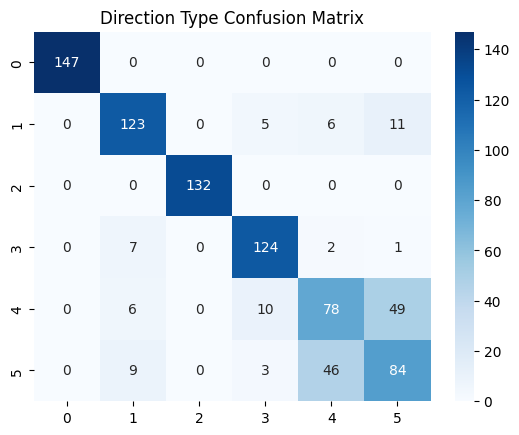

In [71]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm_direction = confusion_matrix(y_dir_test, direction_type_pred)
sns.heatmap(cm_direction, annot=True, fmt='d', cmap='Blues')
plt.title("Direction Type Confusion Matrix")
plt.show()


In [46]:
from sklearn.metrics import classification_report

# Gun type classification report
print("Gun Type Classification Report")
print(classification_report(y_gun_test, gun_type_pred))

# Direction type classification report
print("Direction Type Classification Report")
print(classification_report(y_dir_test, direction_type_pred))

# Distance type classification report
print("Distance Type Classification Report")
print(classification_report(y_dist_test, distance_type_pred))


Gun Type Classification Report
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98       489
         1.0       0.98      0.97      0.98       354

    accuracy                           0.98       843
   macro avg       0.98      0.98      0.98       843
weighted avg       0.98      0.98      0.98       843

Direction Type Classification Report
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       686
         1.0       0.99      0.96      0.97       157

    accuracy                           0.99       843
   macro avg       0.99      0.98      0.98       843
weighted avg       0.99      0.99      0.99       843

Distance Type Classification Report
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       511
         1.0       0.99      0.99      0.99       332

    accuracy                           0.99       843
   macro avg       0.99 

In [47]:
# import csv

# # Filepath for the CSV file
# filepath = 'test_accuracies_xgGA.csv'

# # Calculating accuracies
# gun_accuracy = accuracy_score(y_gun_test, gun_type_pred)
# direction_accuracy = accuracy_score(y_dir_test, direction_type_pred)
# distance_accuracy = accuracy_score(y_dist_test, distance_type_pred)

# # Prepare the data to save
# data_to_save = [
#     ['Metric', 'Accuracy'],
#     ['Gun Type Classification', gun_accuracy],
#     ['Direction Type Classification', direction_accuracy],
#     ['Distance Type Classification', distance_accuracy]
# ]

# # Write the data to a CSV file
# with open(filepath, mode='w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerows(data_to_save)

# print(f"Accuracies saved to {filepath}")


Accuracies saved to test_accuracies_xgGA.csv


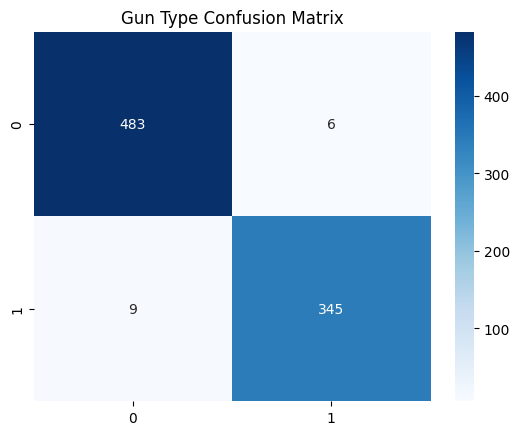

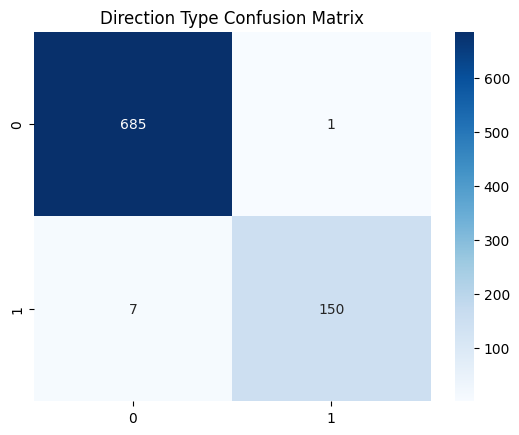

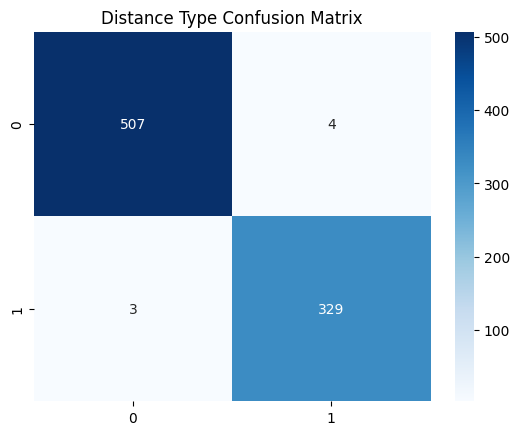

In [48]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix for gun type classification
cm_gun = confusion_matrix(y_gun_test, gun_type_pred)
sns.heatmap(cm_gun, annot=True, fmt='d', cmap='Blues')
plt.title("Gun Type Confusion Matrix")
plt.show()

# Confusion matrix for direction type classification
cm_direction = confusion_matrix(y_dir_test, direction_type_pred)
sns.heatmap(cm_direction, annot=True, fmt='d', cmap='Blues')
plt.title("Direction Type Confusion Matrix")
plt.show()

# Confusion matrix for distance type classification
cm_distance = confusion_matrix(y_dist_test, distance_type_pred)
sns.heatmap(cm_distance, annot=True, fmt='d', cmap='Blues')
plt.title("Distance Type Confusion Matrix")
plt.show()


In [49]:
import plotly.graph_objects as go
plt.clf()
fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['gunshot_output_accuracy'],
                    name='Train'))
fig.add_trace(go.Scatter(
                    y=history.history['val_gunshot_output_accuracy'],
                    name='Valid'))
fig.update_layout(height=500, 
                  width=700,
                  title='Accuracy for gunshot feature',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy')
fig.show()

<Figure size 640x480 with 0 Axes>

In [50]:
plt.clf()
fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['direction_output_accuracy'],
                    name='Train'))
fig.add_trace(go.Scatter(
                    y=history.history['val_direction_output_accuracy'],
                    name='Valid'))
fig.update_layout(height=500, 
                  width=700,
                  title='Accuracy for direction feature',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy')
fig.show()

<Figure size 640x480 with 0 Axes>

In [51]:
plt.clf()
fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['distance_output_accuracy'],
                    name='Train'))
fig.add_trace(go.Scatter(
                    y=history.history['val_distance_output_accuracy'],
                    name='Valid'))
fig.update_layout(height=500, 
                  width=700,
                  title='Accuracy for distance feature',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy')
fig.show()

<Figure size 640x480 with 0 Axes>

In [52]:
# checkpoint=tf.keras.callbacks.ModelCheckpoint('best_model.keras',monitor='val_gunshot_output_accuracy',save_best_only=True,mode='max')
# history=model.fit([X_mfcc_train,X_melspec_train],
#                   {
#                       'gunshot_output':y_gun_train,
#                       'direction_output':y_direction_train,
#                       'distance_output':y_distance_train
#                   },
#                   validation_data=([X_mfcc_val,X_melspec_val],
#                                     {
#                                         'gunshot_output':y_gun_val,
#                                         'direction_output':y_direction_val,
#                                         'distance_output':y_distance_val
#                                     }),
#                     epochs=30,batch_size=32,callbacks=[checkpoint])
# model = create_model(input_shape_mfcc, input_shape_melspec)
# model=tf.keras.models.load_model('best_model.keras')
# model.load_weights('best_model.keras')
# results=model.evaluate([X_mfcc_test,X_melspec_test],{
#                                         'gunshot_output':y_gun_test,
#                                         'direction_output':y_direction_test,
#                                         'distance_output':y_distance_test
#                                     })
# test_loss=results[0]
# test_gun_accuracy=results[1]
# test_direction_accuracy=results[2]
# test_distance_accuracy=results[3]

# # print(f'Test Accuracy:{test_accuracy*100:.2f}%')
# # print(f'Test Loss:{test_loss*100:.2f}%')

In [53]:
# Assume X_train has shape (num_samples, num_features)
num_features = X_test.shape[1]
feature_names = [f'feature_{i+1}' for i in range(num_features)]


c:\Users\abhin\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



Gunshot Model SHAP Summary:


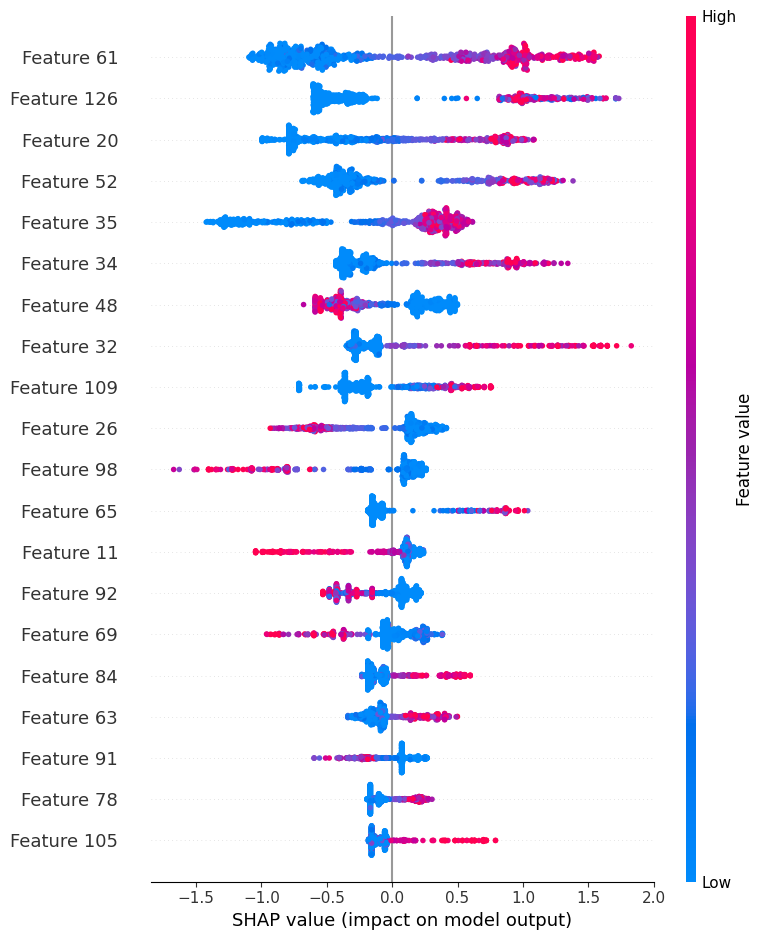

Direction Model SHAP Summary:


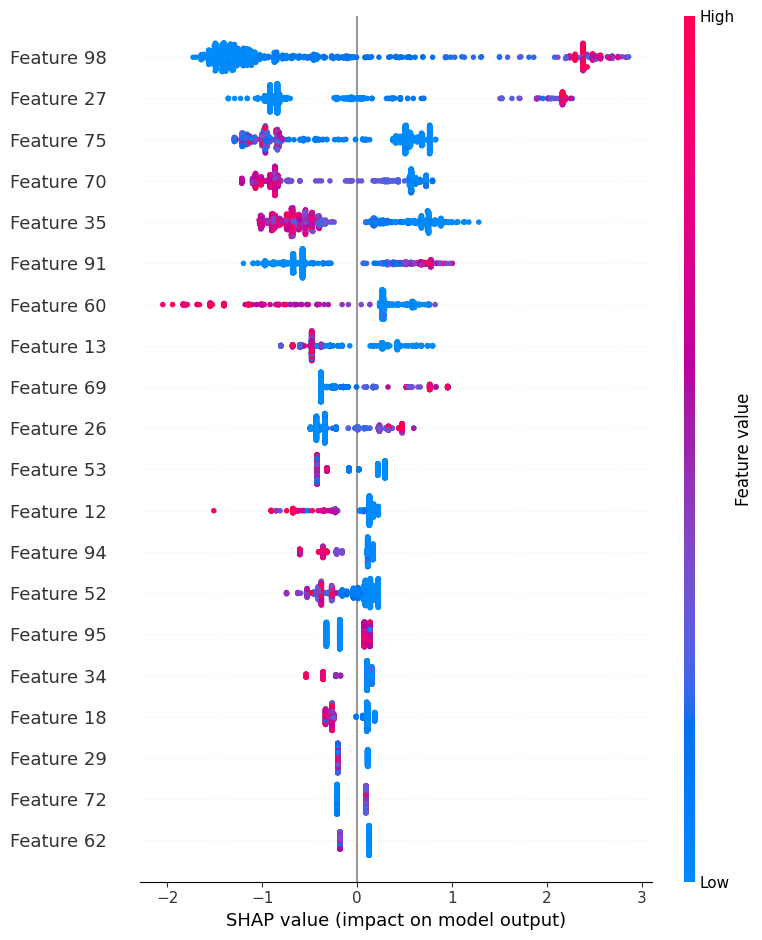

Distance Model SHAP Summary:


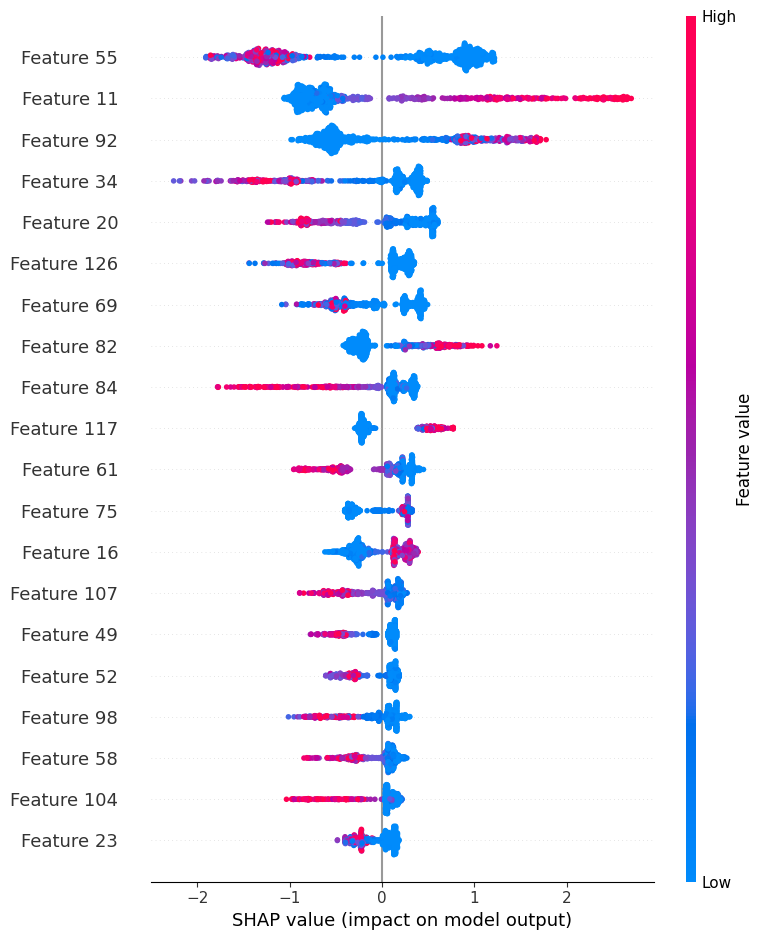

In [54]:
import shap

#if accuracy_gunshot > 0.8:  
explainer_gunshot = shap.TreeExplainer(xgb_model_gun)
shap_values_gunshot = explainer_gunshot.shap_values(X_test)
print("Gunshot Model SHAP Summary:")
shap.summary_plot(shap_values_gunshot, X_test)

#if accuracy_direction > 0.8:
explainer_direction = shap.TreeExplainer(xgb_model_direction)
shap_values_direction = explainer_direction.shap_values(X_test)
print("Direction Model SHAP Summary:")
shap.summary_plot(shap_values_direction, X_test)

#if accuracy_distance > 0.8:
explainer_distance = shap.TreeExplainer(xgb_model_distance)
shap_values_distance = explainer_distance.shap_values(X_test)
print("Distance Model SHAP Summary:")
shap.summary_plot(shap_values_distance, X_test)


100%|██████████| 1/1 [11:25<00:00, 685.65s/it]     


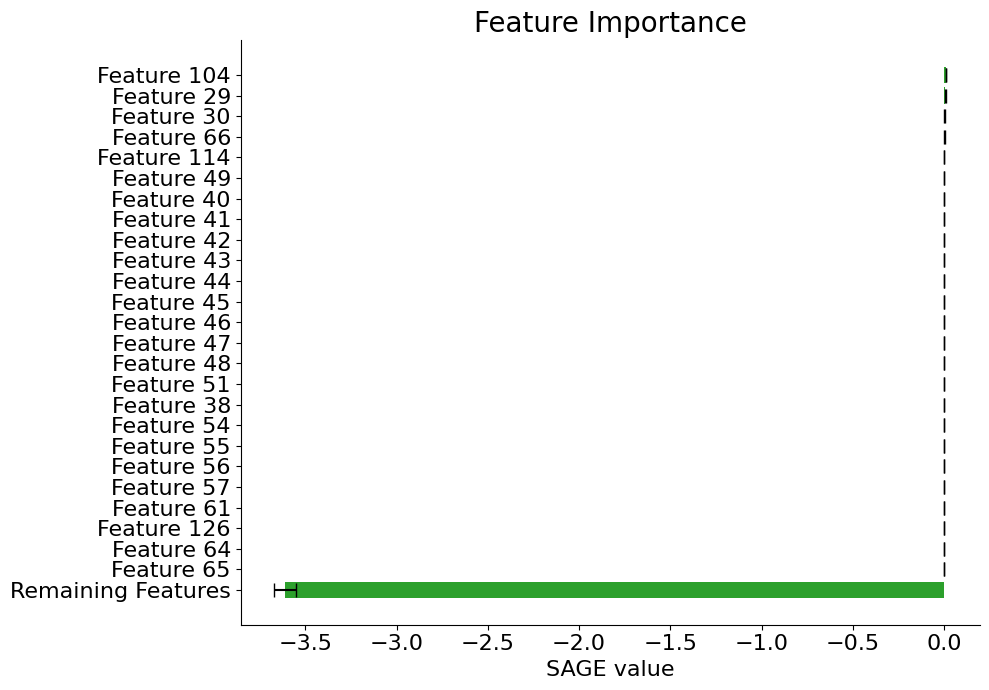

In [55]:
import sage
def loss_fn(y_true,y_pred):
    return np.mean(y_true!=y_pred)
imputer=sage.MarginalImputer(xgb_model_direction,X_test)
estimator=sage.PermutationEstimator(imputer,'cross entropy')
sage_values=estimator(X_test,y_gun_test)
sage_values.plot(max_features=25)

100%|██████████| 1/1 [09:46<00:00, 586.57s/it]     


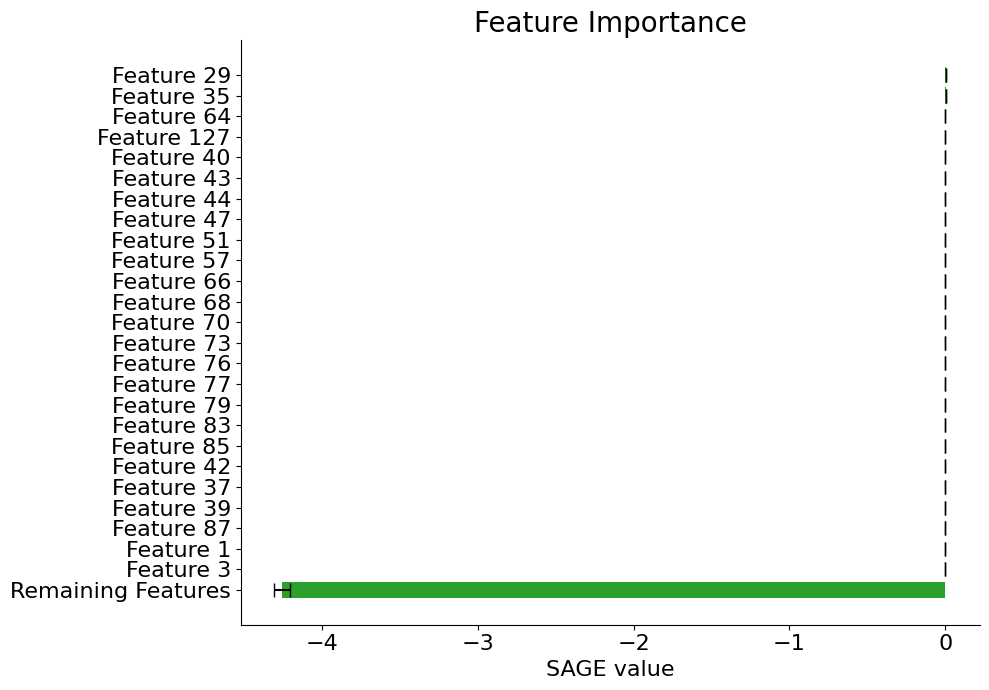

In [56]:
import sage
def loss_fn(y_true,y_pred):
    return np.mean(y_true!=y_pred)
imputer=sage.MarginalImputer(xgb_model_distance,X_test)
estimator=sage.PermutationEstimator(imputer,'cross entropy')
sage_values=estimator(X_test,y_gun_test)
sage_values.plot(max_features=25)

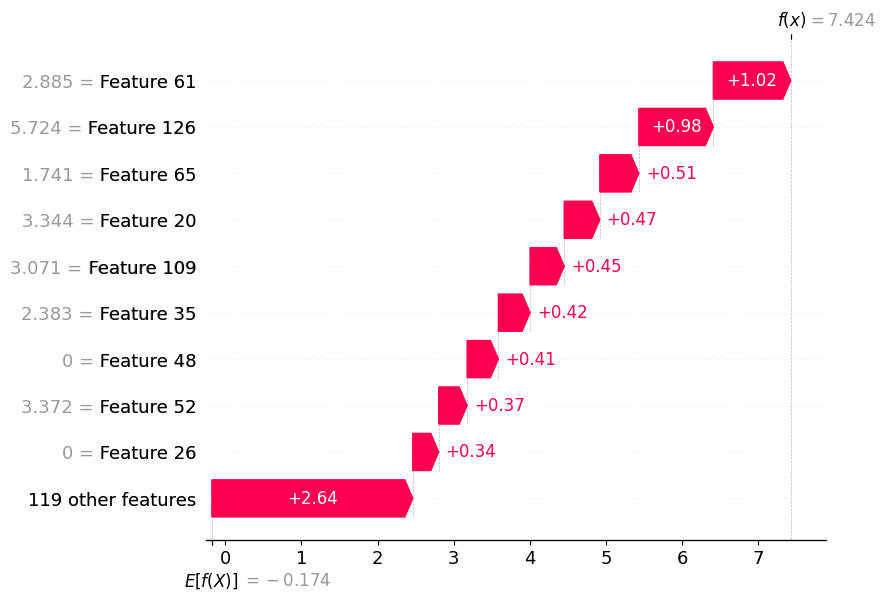

In [57]:
explainer_gunshot = shap.TreeExplainer(xgb_model_gun)
shap_values_gunshot = explainer_gunshot(X_train)
shap.plots.waterfall(shap_values_gunshot[0])